In [73]:
import pandas as pd
import numpy as np
import joblib
import os

# 1. Load raw dataset
data_path = r"D:\RideWise-Predicting-Bike-sharing-Demand\Data\day.csv"
df = pd.read_csv(data_path)

# 2. Drop unneeded columns
df = df.drop(["instant", "dteday","casual","registered","atemp"], axis=1, errors="ignore")

# 3. Categorical columns
cat_cols = ["season", "mnth", "weekday", "weathersit"]
# Create weekend column (1 if weekend, 0 if not weekend)
df['weekend'] = ((df['weekday'] == 0) | (df['weekday'] == 6)).astype(int)
print("Created weekend column (1 for weekend, 0 for weekday)")


# 4. One-hot encode
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# 5. Identify target and feature columns
target = "cnt"
X = df.drop(columns=[target])
y = df[target]

# 6. Store training columns (CRITICAL)
training_columns = df.drop(columns=["cnt"]).columns.tolist()
joblib.dump(training_columns,
            r"D:\RideWise-Predicting-Bike-sharing-Demand\Data\training_columns.pkl")
print("✔ training_columns.pkl updated :", len(training_columns))


# 7. Identify numeric columns (for scaler)
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
joblib.dump(numeric_cols,
            r"D:\RideWise-Predicting-Bike-sharing-Demand\Data\numeric_columns.pkl")

# 8. Save cleaned processed dataset
df.to_csv(r"D:\RideWise-Predicting-Bike-sharing-Demand\Data\day_processed.csv",
          index=False)

print("✔ Preprocessing complete!")
print("✔ Saved processed data")
print("✔ Saved training columns")
print("✔ Saved numeric columns")


Created weekend column (1 for weekend, 0 for weekday)
✔ training_columns.pkl updated : 29
✔ Preprocessing complete!
✔ Saved processed data
✔ Saved training columns
✔ Saved numeric columns


In [79]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error

# -------------------------------------------------------
# 1. LOAD PREPROCESSED DATA
# -------------------------------------------------------
processed_data = r"D:\RideWise-Predicting-Bike-sharing-Demand\Data\day_processed.csv"

df = pd.read_csv(processed_data)

# Load saved training column order
training_columns = joblib.load( r"D:\RideWise-Predicting-Bike-sharing-Demand\Data\training_columns.pkl")
numeric_cols = joblib.load(r"D:\RideWise-Predicting-Bike-sharing-Demand\Data\numeric_columns.pkl")

target_col = "cnt"

X = df[training_columns].copy()
y = df[target_col].copy()

# -------------------------------------------------------
# 2. TRAIN / TEST SPLIT
# -------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------------------------------
# 3. SCALER FIT ONLY ON TRAIN NUMERIC COLUMNS
# -------------------------------------------------------
# Identify numeric columns — ONLY these should be scaled
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Save for evaluation script
joblib.dump(numeric_cols, r"D:\RideWise-Predicting-Bike-sharing-Demand\Data\numeric_columns.pkl")

# Fit scaler ONLY on numeric columns
scaler = StandardScaler()
scaler.fit(X_train[numeric_cols])

# Transform ONLY numeric columns
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# Save scaler
joblib.dump(scaler, r"D:\RideWise-Predicting-Bike-sharing-Demand\Modeling\Saved_Models_files\scaler.pkl")

scaler = StandardScaler()
scaler.fit(X_train[numeric_cols])

# -------------------------------------------------------
# 4. TRAIN LINEAR MODELS
# -------------------------------------------------------
models = {
    "lasso": Lasso(alpha=0.001, random_state=42),
    "ridge": Ridge(alpha=1.0, random_state=42),
    "elasticnet": ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42)
}

rmse_scores = {}

for name, model in models.items():
    print(f"\nTraining {name} model...")

    model.fit(X_train_scaled, y_train)

    preds = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, preds)
    rmse = mse ** 0.5

    rmse_scores[name] = rmse

    print(f"{name} RMSE: {rmse:.4f}")

    # Save model
    joblib.dump(model,r"D:\RideWise-Predicting-Bike-sharing-Demand\Modeling\Saved_Models_files\lasso_model.pkl")
    print(f"{name} model saved.")

print("\nTraining complete.")
print("RMSE summary:", rmse_scores)



Training lasso model...
lasso RMSE: 798.2966
lasso model saved.

Training ridge model...
ridge RMSE: 800.5480
ridge model saved.

Training elasticnet model...
elasticnet RMSE: 798.9453
elasticnet model saved.

Training complete.
RMSE summary: {'lasso': 798.2965647493775, 'ridge': 800.5479652402928, 'elasticnet': 798.9452622704291}


d:\RideWise-Predicting-Bike-sharing-Demand\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.915e+07, tolerance: 2.141e+05
  model = cd_fast.enet_coordinate_descent(
d:\RideWise-Predicting-Bike-sharing-Demand\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.615e+08, tolerance: 2.141e+05
  model = cd_fast.enet_coordinate_descent(


In [80]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# -------------------------------------------------------
# 1. LOAD PREPROCESSED DATA
# -------------------------------------------------------
processed_data = r"D:\RideWise-Predicting-Bike-sharing-Demand\Data\day_processed.csv"
df = pd.read_csv(processed_data)

# Load feature definitions
training_columns = joblib.load(r"D:\RideWise-Predicting-Bike-sharing-Demand\Data\training_columns.pkl")
target_col = "cnt"

X = df[training_columns].copy()
y = df[target_col].copy()

# -------------------------------------------------------
# 2. TRAIN / TEST SPLIT
# -------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------------------------------
# 3. DEFINE TREE MODELS
# -------------------------------------------------------
models = {
    "decision_tree": DecisionTreeRegressor(random_state=42),
    "random_forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "gradient_boost": GradientBoostingRegressor(random_state=42),
}

rmse_scores = {}

# -------------------------------------------------------
# 4. TRAIN EACH MODEL
# -------------------------------------------------------
for name, model in models.items():
    print(f"\nTraining {name} ...")

    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    rmse = mse ** 0.5

    rmse_scores[name] = rmse

    print(f"{name} RMSE: {rmse:.4f}")

    # save model
    model_path = os.path.join(processed_folder, f"{name}.pkl")
    processed_folder = r"D:\RideWise-Predicting-Bike-sharing-Demand\Modeling\Saved_Models_files"
    joblib.dump(model, model_path)
    print(f"{name} saved to {model_path}")

# -------------------------------------------------------
# 5. SHOW SUMMARY
# -------------------------------------------------------
print("\n==============================")
print("TREE MODEL RMSE SUMMARY")
for m, r in rmse_scores.items():
    print(m, "→", r)
print("==============================")



Training decision_tree ...
decision_tree RMSE: 989.7336
decision_tree saved to D:\RideWise-Predicting-Bike-sharing-Demand\Modeling\Saved_Models_files\decision_tree.pkl

Training random_forest ...
random_forest RMSE: 699.7226
random_forest saved to D:\RideWise-Predicting-Bike-sharing-Demand\Modeling\Saved_Models_files\random_forest.pkl

Training gradient_boost ...
gradient_boost RMSE: 661.0786
gradient_boost saved to D:\RideWise-Predicting-Bike-sharing-Demand\Modeling\Saved_Models_files\gradient_boost.pkl

TREE MODEL RMSE SUMMARY
decision_tree → 989.733641073248
random_forest → 699.7225573071242
gradient_boost → 661.0785581540231


In [84]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge, ElasticNet

# ----------------------------------------------------
# CONFIG
# ----------------------------------------------------
processed_folder = r"D:\RideWise-Predicting-Bike-sharing-Demand\Modeling\Saved_Models_files"
processed_data = r"D:\RideWise-Predicting-Bike-sharing-Demand\Data\day_processed.csv"
test_data_path = r"D:\RideWise-Predicting-Bike-sharing-Demand\Data\day(new).csv"

# ----------------------------------------------------
# 1. LOAD TRAIN DATA TO GET COLUMN ORDER
# ----------------------------------------------------
train_df = pd.read_csv(processed_data)
training_columns = train_df.drop(columns=["cnt"]).columns.tolist()
print("✔ Loaded training columns:", len(training_columns))

# ----------------------------------------------------
# 2. LOAD TEST DATA
# ----------------------------------------------------
df_test = pd.read_csv(test_data_path)

if "cnt" in df_test.columns:
    y_true = df_test["cnt"].copy()
else:
    raise ValueError("❌ Test data must contain 'cnt' column")

# ----------------------------------------------------
# 3. CREATE WEEKEND EXACTLY LIKE TRAINING
# ----------------------------------------------------
if "weekend" not in df_test.columns:

    if "weekday" in df_test.columns:
        df_test["weekend"] = df_test["weekday"].isin([0, 6]).astype(int)

    else:
        df_test["weekend"] = 0
        if "weekday_0" in df_test.columns:
            df_test["weekend"] |= df_test["weekday_0"]
        if "weekday_6" in df_test.columns:
            df_test["weekend"] |= df_test["weekday_6"]

# ----------------------------------------------------
# 4. ONE-HOT ENCODING SAME AS TRAINING
# ----------------------------------------------------
cat_cols = ["season", "mnth", "weekday", "weathersit"]

for col in cat_cols:
    if col in df_test.columns:
        df_test = pd.get_dummies(df_test, columns=[col], drop_first=True)

# ----------------------------------------------------
# 5. ADD MISSING TRAINING COLUMNS
# ----------------------------------------------------
for col in training_columns:
    if col not in df_test.columns:
        df_test[col] = 0

df_test = df_test[training_columns]

# ----------------------------------------------------
# 6. LOAD SCALER
# ----------------------------------------------------
scaler_path = os.path.join(processed_folder, "scaler.pkl")

if os.path.exists(scaler_path):
    scaler = joblib.load(scaler_path)
    print("✔ Scaler Loaded")
else:
    scaler = None
    print("⚠ No scaler found")

def needs_scaling(model):
    return isinstance(model, (Lasso, Ridge, ElasticNet))

numeric_cols = df_test.select_dtypes(include=[np.number]).columns.tolist()

# ----------------------------------------------------
# 7. LOAD ONLY NON-LINEAR MODELS
# ----------------------------------------------------
model_files = [
    f for f in os.listdir(processed_folder)
    if f.endswith(".pkl")
    and "scaler" not in f
    and "linear" not in f.lower()
]

print("\nFound models:")
print("\n".join(model_files))

results = {}
predictions_all = {}

# ----------------------------------------------------
# 8. EVALUATE MODELS
# ----------------------------------------------------
for model_file in model_files:
    print("\nEvaluating:", model_file)

    model = joblib.load(os.path.join(processed_folder, model_file))

    X_eval = df_test.copy()

    if scaler is not None and needs_scaling(model):
        X_eval[numeric_cols] = scaler.transform(X_eval[numeric_cols])

    preds = model.predict(X_eval)

    rmse = (mean_squared_error(y_true, preds)) ** 0.5
    results[model_file] = rmse
    predictions_all[model_file] = preds

    print(f"RMSE: {rmse:.3f}")

# ----------------------------------------------------
# 9. BEST MODEL
# ----------------------------------------------------
best_model = min(results, key=results.get)
best_rmse = results[best_model]

print("\n==============================")
print("🏆 BEST MODEL SELECTED")
print("Model:", best_model)
print("RMSE :", best_rmse)
print("==============================")

# ----------------------------------------------------
# 10. SAVE RESULTS
# ----------------------------------------------------
output = pd.DataFrame({"Actual_cnt": y_true})

for name, preds in predictions_all.items():
    output[name.replace(".pkl", "") + "_pred"] = preds

save_path = os.path.join(processed_folder, "model_comparison_results.csv")
output.to_csv(save_path, index=False)

print("\n📄 Saved at:", save_path)


✔ Loaded training columns: 29
✔ Scaler Loaded

Found models:
decision_tree(CV).pkl
decision_tree.pkl
elastic_net_model(CV).pkl
elastic_net_model.pkl
gradient_boost(CV).pkl
gradient_boost.pkl
lasso_model(CV).pkl
lasso_model.pkl
randomforest.pkl
random_forest(CV).pkl
random_forest.pkl
ridge_model(CV).pkl
ridge_model.pkl

Evaluating: decision_tree(CV).pkl
RMSE: 4846.705

Evaluating: decision_tree.pkl
RMSE: 1850.540

Evaluating: elastic_net_model(CV).pkl
RMSE: 4884.835

Evaluating: elastic_net_model.pkl
RMSE: 7405.434

Evaluating: gradient_boost(CV).pkl
RMSE: 4863.609

Evaluating: gradient_boost.pkl
RMSE: 3116.186

Evaluating: lasso_model(CV).pkl
RMSE: 4907.713

Evaluating: lasso_model.pkl
RMSE: 49300.658

Evaluating: randomforest.pkl
RMSE: 4853.223

Evaluating: random_forest(CV).pkl
RMSE: 4850.945

Evaluating: random_forest.pkl


d:\RideWise-Predicting-Bike-sharing-Demand\env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
d:\RideWise-Predicting-Bike-sharing-Demand\env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
d:\RideWise-Predicting-Bike-sharing-Demand\env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


RMSE: 1701.535

Evaluating: ridge_model(CV).pkl
RMSE: 4907.713

Evaluating: ridge_model.pkl
RMSE: 7404.698

🏆 BEST MODEL SELECTED
Model: random_forest.pkl
RMSE : 1701.5350054808487

📄 Saved at: D:\RideWise-Predicting-Bike-sharing-Demand\Modeling\Saved_Models_files\model_comparison_results.csv


d:\RideWise-Predicting-Bike-sharing-Demand\env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
d:\RideWise-Predicting-Bike-sharing-Demand\env\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


In [85]:
# ----------------------------------------------------
# Create Actual vs Predicted Table for BEST MODEL
# ----------------------------------------------------
best_preds = predictions_all[best_model]

comparison_df = pd.DataFrame({
    "Actual_Count": y_true.values,
    "Predicted_Count": best_preds
})

print("\n📊 Actual vs Predicted (first 20 rows):")
print(comparison_df.head(20))



📊 Actual vs Predicted (first 20 rows):
    Actual_Count  Predicted_Count
0            985         2357.380
1            801         2505.785
2           1349         2645.615
3           1562         2650.145
4           1600         2638.245
5           1606         2667.385
6           1510         2630.250
7            959         2357.380
8            822         2508.500
9           1321         2645.615
10          1263         2631.750
11          1162         2638.245
12          1406         2667.385
13          1421         2656.430
14          1248         2357.380
15          1204         2508.500
16          1000         2558.975
17           683         2631.750
18          1650         2617.470
19          1927         2646.375


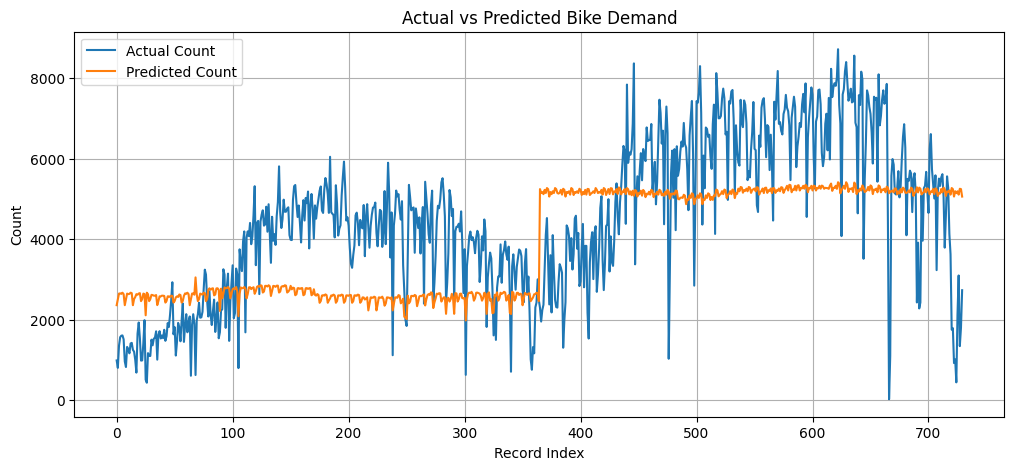

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(comparison_df["Actual_Count"].values, label="Actual Count")
plt.plot(comparison_df["Predicted_Count"].values, label="Predicted Count")
plt.title("Actual vs Predicted Bike Demand")
plt.xlabel("Record Index")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()


In [88]:
comparison_df.to_csv(
    os.path.join(processed_folder, "actual_vs_predicted.csv"),
    index=False
)

print("📄 Saved Actual vs Predicted CSV.")


📄 Saved Actual vs Predicted CSV.
